<a href="https://colab.research.google.com/github/surajsy/Assignment1/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mitdeeplearning

import mitdeeplearning as mdl

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm

assert len(tf.config.list_physical_devices('GPU')) > 0

In [ ]:
dataset = tfds.load('cifar10')
train = dataset['train']
test = dataset['test']

In [ ]:
real = (np.array([d['image'] for d in train.as_numpy_iterator()]).astype(np.float32)/255.0 - 0.5)*2

In [ ]:
np.min(real)

-1.0

In [ ]:
def get_batch(images, batch_size):
  idx = np.random.choice(len(images), batch_size)
  image_batch = np.array(images)[idx]
  return image_batch

In [ ]:
def get_noise(batch_size, latent_size):
  return np.random.normal(size=[batch_size, latent_size])

In [ ]:
def get_fake_samples(batch_size):
  return 2*np.random.uniform(size=[batch_size,32,32,3]) - 1

In [ ]:
latent_dim = 100
batch_size = 32
gen_lr = 1e-4
dis_lr = 1e-4
num_training_iterations = 10000
num = 5

In [ ]:
def wgan_discriminator_loss(real_prediction, fake_prediction):
  return tf.math.reduce_mean(real_prediction) - tf.math.reduce_mean(fake_prediction)

def wgan_generator_loss(fake_prediction):
  return tf.math.reduce_mean(fake_prediction)

In [ ]:
def generator_model(latent_size):
  noise = tf.keras.layers.Input(shape=(latent_size,), name='noise')
  
  dense = tf.keras.layers.Dense(4*4*256)(noise)
  dense = tf.keras.layers.BatchNormalization()(dense)
  dense = tf.keras.layers.LeakyReLU(alpha=0.2)(dense)

  reshaped = tf.keras.layers.Reshape((4,4,256))(dense)
  upsample = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same')(reshaped)
  # attn1 = tf.keras.layers.Attention()([upsample,upsample])
  # v1 = tf.Variable(initial_value=0.0, trainable=True, name='v1')
  # upsample = upsample + v1*attn1
  upsample = tf.keras.layers.BatchNormalization()(upsample)
  upsample = tf.keras.layers.LeakyReLU(alpha=0.2)(upsample)

  upsample = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same')(upsample)
  # attn2 = tf.keras.layers.Attention()([upsample,upsample])
  # v2 = tf.Variable(initial_value=0.0, trainable=True, name='v2')
  # upsample = upsample + v2*attn2
  upsample = tf.keras.layers.BatchNormalization()(upsample)
  upsample = tf.keras.layers.LeakyReLU(alpha=0.2)(upsample)

  upsample = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding='same')(upsample)
  # attn3 = tf.keras.layers.Attention()([upsample,upsample])
  # v3 = tf.Variable(initial_value=0.0, trainable=True, name='v3')
  # upsample = upsample + v3*attn3 
  upsample = tf.keras.layers.BatchNormalization()(upsample)
  upsample = tf.keras.layers.LeakyReLU(alpha=0.2)(upsample)

  upsample = tf.keras.layers.Conv2D(filters=3, kernel_size=3, padding='same')(upsample)
  # attn4 = tf.keras.layers.Attention()([upsample,upsample])
  # v4 = tf.Variable(initial_value=0.0, trainable=True, name='v4')
  # upsample = upsample + v4*attn4
  upsample = tf.keras.layers.BatchNormalization()(upsample)
  upsample = tf.keras.activations.tanh(upsample)

  model = tf.keras.Model(inputs=noise,outputs=upsample)
  model.summary()
  return model

In [ ]:
def discriminator_model():
  image = tf.keras.layers.Input(shape=[32,32,3])

  conv = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)(image)
  conv = tf.keras.layers.LeakyReLU()(conv)

  conv = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(conv)
  # attn1 = tf.keras.layers.Attention()([conv,conv])
  # v1 = tf.Variable(initial_value=0.0, trainable=True, name='v1')
  # conv = v1*attn1 + conv
  conv = tf.keras.layers.BatchNormalization()(conv)
  conv = tf.keras.layers.LeakyReLU()(conv)

  conv = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(conv)
  conv = tf.keras.layers.BatchNormalization()(conv)
  # attn2 = tf.keras.layers.Attention()([conv,conv])
  # v2 = tf.Variable(initial_value=0.0, trainable=True, name='v2')
  # conv = v2*attn2 + conv
  conv = tf.keras.layers.LeakyReLU()(conv)

  conv = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(conv)
  conv = tf.keras.layers.BatchNormalization()(conv)
  # attn3 = tf.keras.layers.Attention()([conv,conv])
  # v3 = tf.Variable(initial_value=0.0, trainable=True, name='v3')
  # conv = v3*attn3 + conv
  conv = tf.keras.layers.LeakyReLU()(conv)

  conv = tf.keras.layers.Flatten()(conv)
  conv = tf.keras.layers.Dropout(0.4)(conv)
  out = tf.keras.layers.Dense(1)(conv)

  model = tf.keras.Model(inputs=image, outputs=out)
  # model.compile(loss=wgan_discriminator_loss, optimizer=dis_opt)
  model.summary()
  return model  

In [ ]:
# def gan_model(gen, disc):
#   model = tf.keras.Sequential()
#   disc.trainable = False
#   model.add(gen)
#   model.add(disc)
#   return model
gen_opt = tf.keras.optimizers.Adam(learning_rate=gen_lr)
dis_opt = tf.keras.optimizers.Adam(learning_rate=dis_lr)

In [ ]:
generator = generator_model(latent_dim)
discriminator = discriminator_model()
# gan = gan_model(generator, discriminator)

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
dense_43 (Dense)             (None, 4096)              413696    
_________________________________________________________________
batch_normalization_177 (Bat (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_164 (LeakyReLU)  (None, 4096)              0         
_________________________________________________________________
reshape_24 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_82 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_178 (Bat (None, 8, 8, 128)         512

In [ ]:
# gan.summary()

In [ ]:
discriminator.summary()

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
leaky_re_lu_160 (LeakyReLU)  (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 30, 30, 128)       73856     
_________________________________________________________________
batch_normalization_174 (Bat (None, 30, 30, 128)       512       
_________________________________________________________________
leaky_re_lu_161 (LeakyReLU)  (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 15, 15, 128)       147

In [ ]:
@tf.function
def train_step(image_batch): 
  with tf.GradientTape() as disc_tape:
    real_prediction = discriminator(image_batch)
    
    noise = get_noise(batch_size, latent_dim)
    fake_batch = generator(noise)

    fake_prediction = discriminator(fake_batch)

    gen_loss = wgan_generator_loss(fake_prediction)
    dis_loss = wgan_discriminator_loss(real_prediction, fake_prediction)
  dis_grads = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
  dis_opt.apply_gradients(zip(dis_grads, discriminator.trainable_variables))

  for i in range(5):
    with tf.GradientTape() as gen_tape:
      noise = get_noise(batch_size, latent_dim)
      fake_batch = generator(noise)

      fake_prediction = discriminator(fake_batch)

      gen_loss = wgan_generator_loss(fake_prediction)
      dis_loss = wgan_discriminator_loss(real_prediction, fake_prediction)

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_opt.apply_gradients(zip(gen_grads, generator.trainable_variables))
    # tf.print(gen_loss,dis_loss)
  return gen_loss, dis_loss


Exception ignored in: <bound method tqdm.__del__ of  17%|█▋        | 1716/10000 [06:09<26:08,  5.28it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 1062, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 1245, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/std.py", line 564, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 53, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1056, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.6/threading.py", line 1072, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

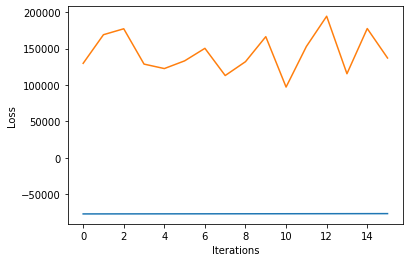

In [ ]:
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  real_batch = get_batch(real, batch_size)
  # Grab a batch and propagate it through the network
  loss = train_step(real_batch)

  # Update the progress bar
  history.append(loss)
  plotter.plot(history)

  if iter % 100 == 0:
    history.clear()

In [ ]:
fake_batch[2]<0

In [ ]:
noise = get_noise(batch_size, latent_dim)
fake_batch = generator(noise)

In [ ]:
from matplotlib.pyplot import imshow, figure

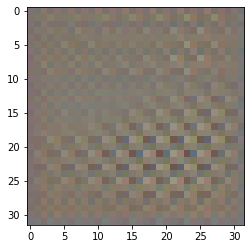

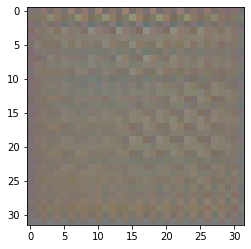

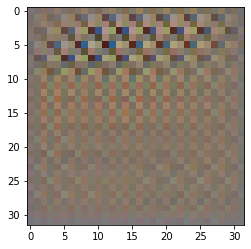

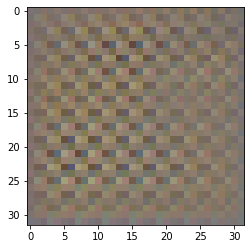

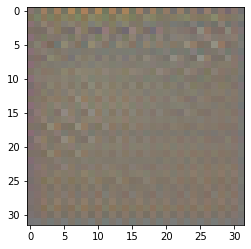

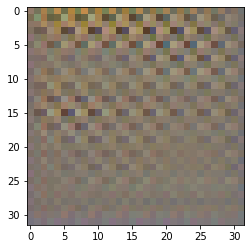

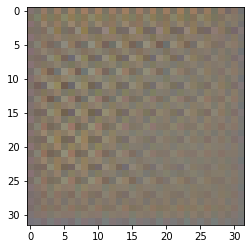

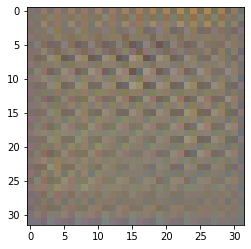

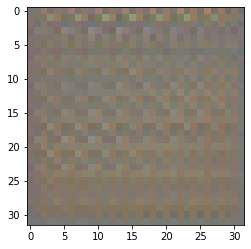

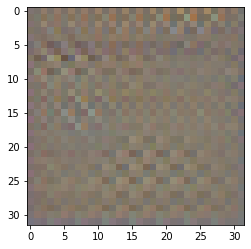

In [ ]:
for i in range(10):
  figure()
  imshow((fake_batch[i]+1)/2)